# Expected Completion
Attempting to predict completion percentage.

## Libraries

In [1]:
import logging
import sys
import warnings

import numpy as np
import pandas as pd
from pandas_gbq import read_gbq

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    roc_auc_score,
    precision_score,
    recall_score,
    accuracy_score,
    log_loss
)

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from xgboost import (
    XGBClassifier,
    plot_importance
)

from pygam import (
    GAM,
    LogisticGAM,
    s,
    f,
    te
)

from yellowbrick.classifier import (
    ClassPredictionError,
    ClassificationReport,
    ROCAUC,
    PrecisionRecallCurve,
    DiscriminationThreshold
)

## Setup

In [2]:
# Supress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# BQ Logging
logger = logging.getLogger('pandas_gbq')
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler(stream=sys.stdout))

In [4]:
# Pandas display
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [5]:
# Seaborn
sns.set(rc={'figure.figsize': (16, 9)})

In [6]:
# BigQuery
PROJECT_ID = 'ad-big-data-bowl'
SERVICE_ACCOUNT_PATH = '../credentials/bigquery-admin.json'

In [31]:
SQL_BASE = \
"""
SELECT
  *,
  COS(qb_pass_direction - throw_direction) * qb_pass_speed AS qb_pass_velo_par,
  SIN(qb_pass_direction - throw_direction) * qb_pass_speed AS qb_pass_velo_orth
FROM
  (
    SELECT
      gameplay_id,
      MAX(CASE WHEN position = 'QB' THEN nfl_id END) AS qb_nfl_id,
      MAX(CASE WHEN position = 'QB' THEN display_name END) AS qb_name,
      MAX(CASE WHEN targeted_receiver_flag = 1 THEN nfl_id END) AS receiver_nfl_id,
      MAX(CASE WHEN targeted_receiver_flag = 1 THEN display_name END) AS receiver_name,
      MAX(pass_complete_flag) AS pass_complete_flag,
      MAX(play_epa) AS play_epa,
      MAX(play_air_epa) AS play_air_epa,
      MAX(play_yac_epa) AS play_yac_epa,
      MAX(play_comp_air_epa) AS play_comp_air_epa,
      MAX(play_comp_yac_epa) AS play_comp_yac_epa,
      MAX(time_to_pass) AS time_to_pass,
      MAX(CASE WHEN position = 'QB' THEN pass_speed END) AS qb_pass_speed,
      MAX(CASE WHEN position = 'QB' THEN pass_direction END) AS qb_pass_direction,
      MAX(throw_direction) AS throw_direction,
      MAX(throw_distance) AS throw_distance,
      MAX(arrived_endline_distance) AS arrived_endline_distance,
      MAX(arrived_sideline_distance) AS arrived_sideline_distance,
      MAX(FLOOR(arrived_ball_x_rel)) AS arrived_x_rel,
      MAX(FLOOR(arrived_ball_y)) AS arrived_y,
      MAX(yardline_true) AS yardline_true,
      MIN(CASE WHEN player_side = 'defense' THEN pass_ball_distance END) AS closest_pass_rusher_distance,
      MIN(CASE WHEN player_side = 'defense' THEN arrived_ball_distance END) AS closest_pass_defender_distance,
      MIN(CASE WHEN player_side = 'defense' THEN arrived_pred_ball_distance END) AS closest_pred_pass_defender_distance,
      COALESCE(SUM(CASE WHEN player_side = 'defense' AND pass_ball_distance < 1 THEN 1 END), 0) AS pass_rushers_1yd,
      COALESCE(SUM(CASE WHEN player_side = 'defense' AND pass_ball_distance < 2 THEN 1 END), 0) AS pass_rushers_2yd,
      COALESCE(SUM(CASE WHEN player_side = 'defense' AND pass_ball_distance < 3 THEN 1 END), 0) AS pass_rushers_3yd,
      COALESCE(SUM(CASE WHEN player_side = 'defense' AND arrived_ball_distance < 2 THEN 1 END), 0) AS pass_defenders_2yd,
      COALESCE(SUM(CASE WHEN player_side = 'defense' AND arrived_ball_distance < 4 THEN 1 END), 0) AS pass_defenders_4yd,
      COALESCE(SUM(CASE WHEN player_side = 'defense' AND arrived_ball_distance < 5 THEN 1 END), 0) AS pass_defenders_5yd
    FROM
      (
        SELECT
          *
        FROM
          `ad-big-data-bowl.workspace.passes_enhanced`
        WHERE
          personnel_offense_type = 'conventional'
            AND play_epa IS NOT NULL
      )
    GROUP BY 1
  )
"""

In [32]:
# sql_base = SQL_BASE.format(**PARAMS)
sql_base = SQL_BASE

df_base = pd.read_gbq(query=sql_base,
                      project_id=PROJECT_ID,
                      dialect='standard',
                      private_key=SERVICE_ACCOUNT_PATH)

df_copy = df_base.copy()

  Elapsed 6.04 s. Waiting...
  Elapsed 7.3 s. Waiting...
  Elapsed 8.71 s. Waiting...
  Elapsed 10.14 s. Waiting...
  Elapsed 11.4 s. Waiting...
  Elapsed 12.8 s. Waiting...
  Elapsed 14.23 s. Waiting...
  Elapsed 15.46 s. Waiting...
  Elapsed 16.69 s. Waiting...
Total time taken 19.85 s.
Finished at 2019-01-20 13:08:22.


In [33]:
df_base.head()

gameplay_id  qb_nfl_id     qb_name  receiver_nfl_id   receiver_name  \
0  2017090700-1025    2504211   Tom Brady         2649.000  Danny Amendola   
1  2017090700-1049    2504211   Tom Brady      2543498.000   Brandin Cooks   
2  2017090700-1130    2504211   Tom Brady      2539265.000    Rex Burkhead   
3  2017090700-1274    2506340  Alex Smith      2554630.000     Ross Travis   
4  2017090700-1397    2504211   Tom Brady         2649.000  Danny Amendola   

   pass_complete_flag  play_epa  play_air_epa  play_yac_epa  \
0                   1     2.627         2.626         0.001   
1                   1     0.736        -0.482         1.219   
2                   0    -0.502         2.086        -2.589   
3                   0    -0.615         0.983        -1.598   
4                   1     2.365         2.137         0.229   

   play_comp_air_epa  play_comp_yac_epa  time_to_pass  qb_pass_speed  \
0              2.626              0.001         3.500          0.160   
1             -0.482              1.219         2.900          1.240   
2              0.000              0.000         2.300          0.350   
3              0.000              0.000         4.700          1.760   
4              2.137              0.229         2.400          0.580   

   qb_pass_direction  throw_direction  throw_distance  \
0             31.750           88.410          27.740   
1             80.880           38.820          10.050   
2             23.990           32.660          33.800   
3            306.010           60.470          23.940   
4            318.030          328.810          24.390   

   arrived_endline_distance  arrived_sideline_distance  arrived_x_rel  \
0                    57.600                     23.830         24.000   
1                    53.400                     22.070          1.000   
2                     8.130                     -3.130         13.000   
3                    47.070                     -2.130         17.000   
4                    77.670                      5.770          6.000   

   arrived_y  yardline_true  closest_pass_rusher_distance  \
0     29.000         72.000                         2.910   
1     31.000         45.000                         1.950   
2     56.000         12.000                         2.290   
3     55.000         55.000                         2.250   
4     47.000         74.000                         3.520   

   closest_pass_defender_distance  closest_pred_pass_defender_distance  \
0                           2.170                                2.840   
1                           5.180                                4.570   
2                           1.340                               13.340   
3                           2.110                                3.950   
4                           5.530                                9.450   

   pass_rushers_1yd  pass_rushers_2yd  pass_rushers_3yd  pass_defenders_2yd  \
0                 0                 0                 1                   0   
1                 0                 1                 1                   0   
2                 0                 0                 1                   1   
3                 0                 0                 1                   0   
4                 0                 0                 0                   0   

   pass_defenders_4yd  pass_defenders_5yd  qb_pass_velo_par  qb_pass_velo_orth  
0                   1                   1             0.159             -0.018  
1                   0                   0            -0.427             -1.164  
2                   1                   1            -0.255             -0.240  
3                   1                   1             1.548              0.837  
4                   0                   0            -0.124              0.567

## Data preparation

In [34]:
# Base filters
_under_6s = df_base['time_to_pass'] < 6
_rusher_10y = df_base['closest_pass_rusher_distance'] < 10
_defender_30 = df_base['closest_pred_pass_defender_distance'] < 30
_inbounds_4 = df_base['arrived_sideline_distance'] > -4
_beyond_deep_backfield = df_base['arrived_x_rel'] > -10

df_pred = df_base[_under_6s & _rusher_10y & _defender_30 & _inbounds_4 & _beyond_deep_backfield]

In [35]:
# Pred filters
_complete = df_pred['pass_complete_flag'] == 1
_incomplete = df_pred['pass_complete_flag'] == 0

## Plotting

In [36]:
key_features = [
    'time_to_pass',
    'qb_pass_speed',
    'qb_pass_velo_par',
    'qb_pass_velo_orth',
    'throw_distance',
    'arrived_endline_distance',
    'arrived_sideline_distance',
    'closest_pass_rusher_distance',
    'closest_pass_defender_distance',
    'closest_pred_pass_defender_distance'
]

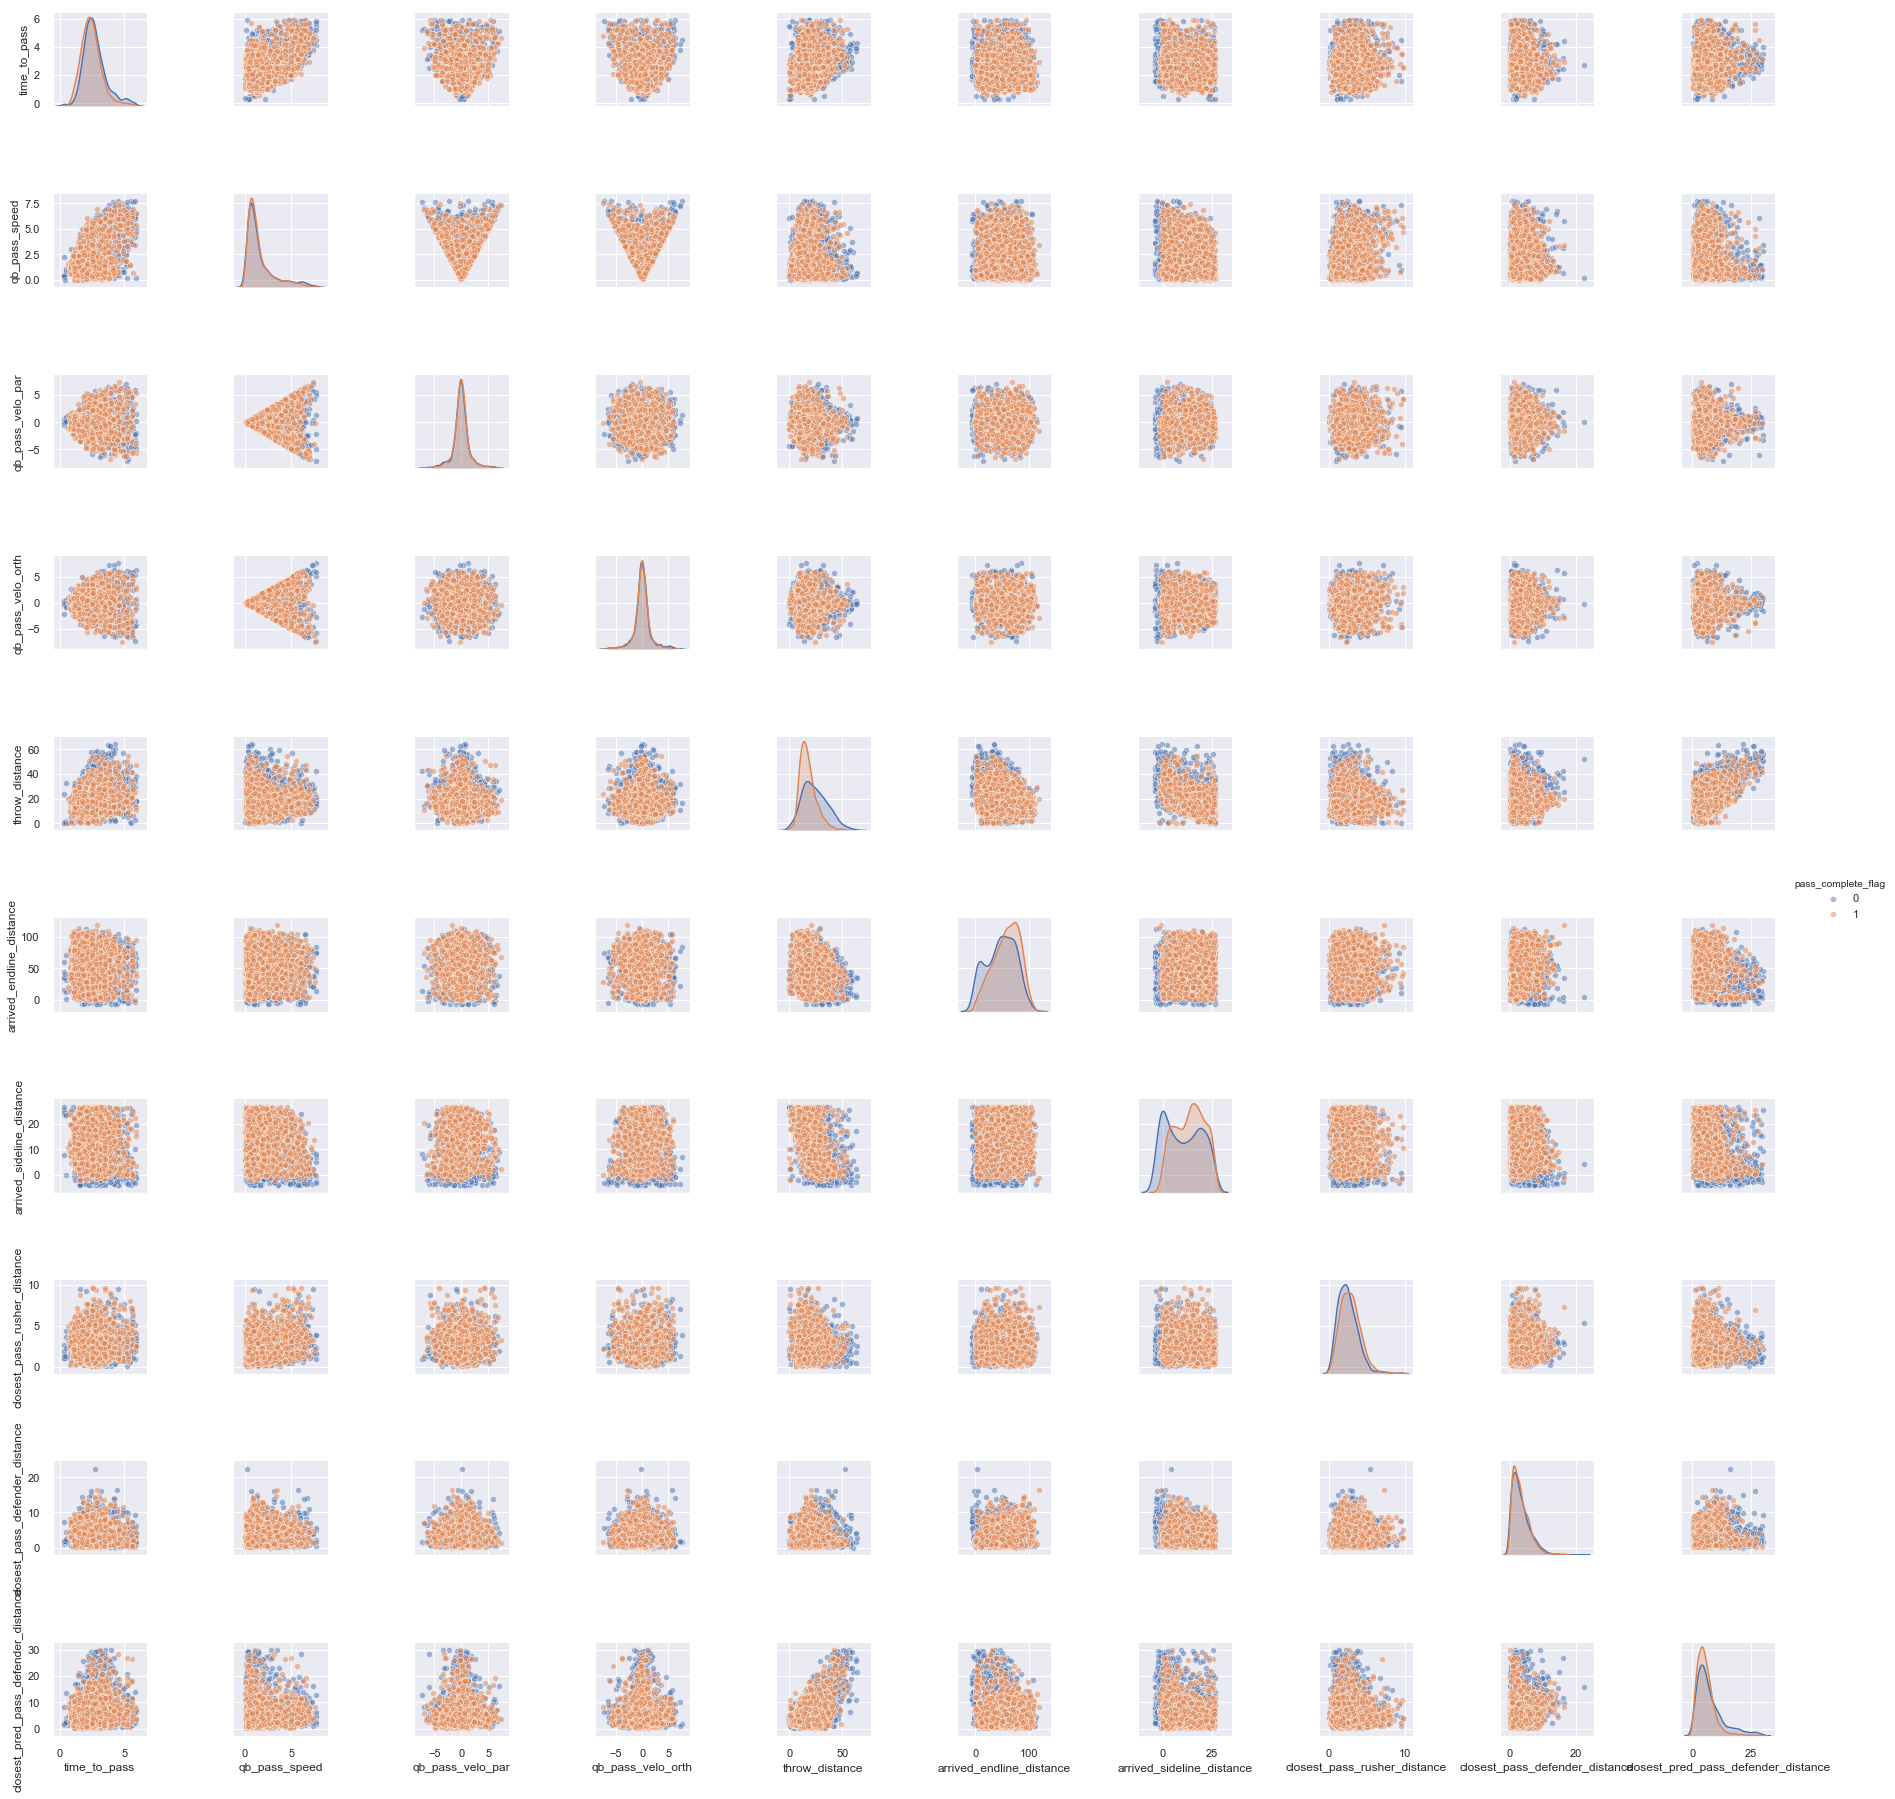

In [37]:
sns.pairplot(data=df_pred,
             vars=key_features,
             hue='pass_complete_flag',
             plot_kws={'alpha': 0.5})

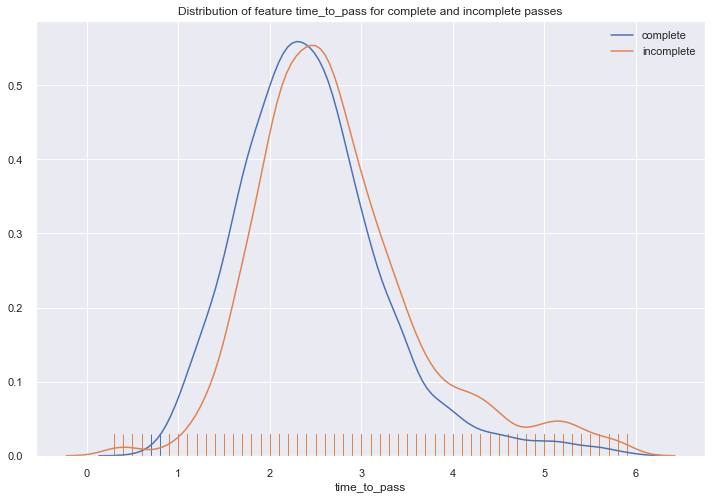

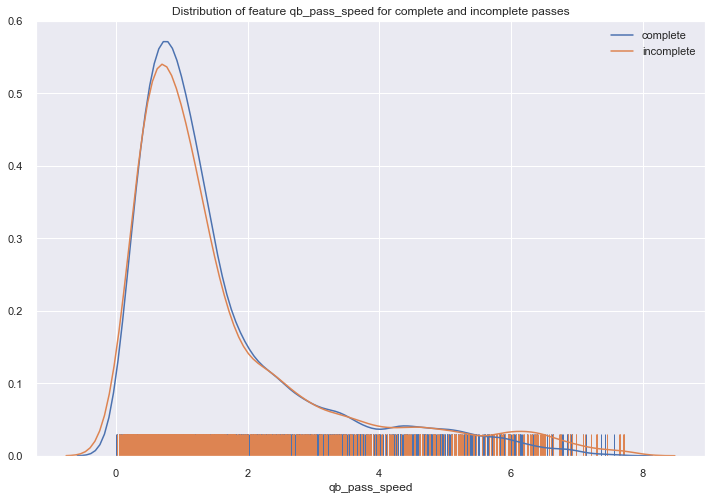

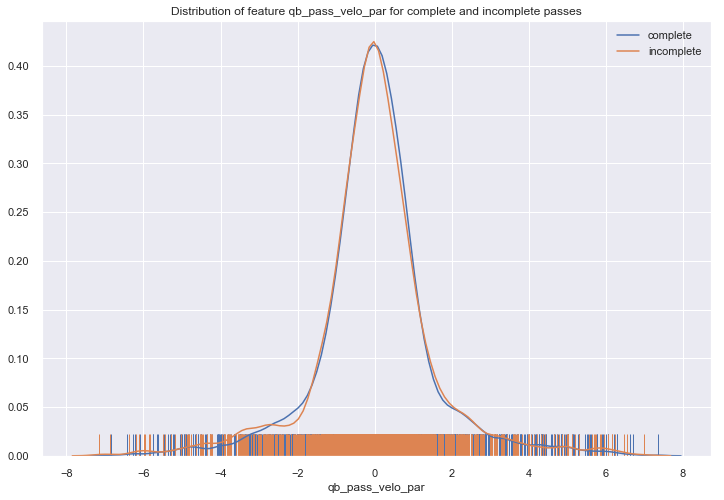

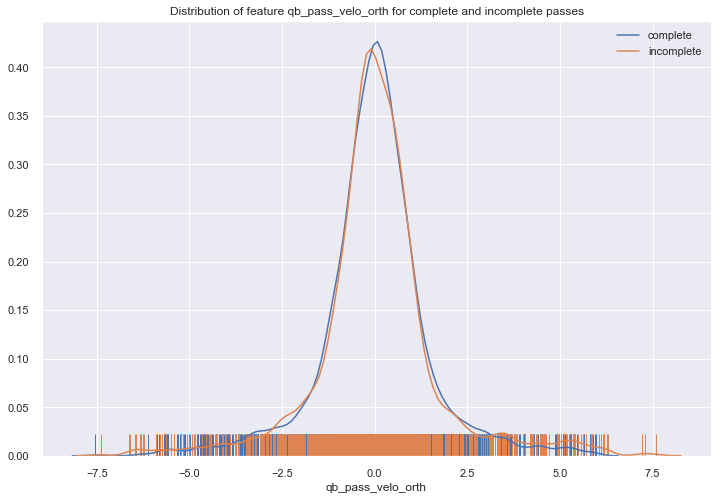

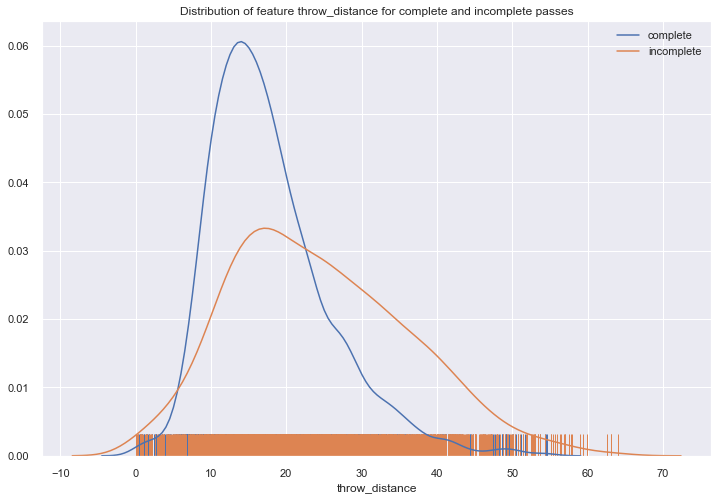

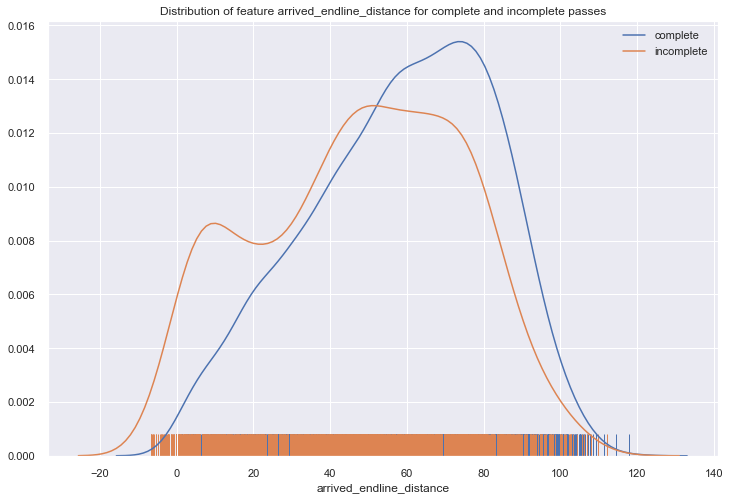

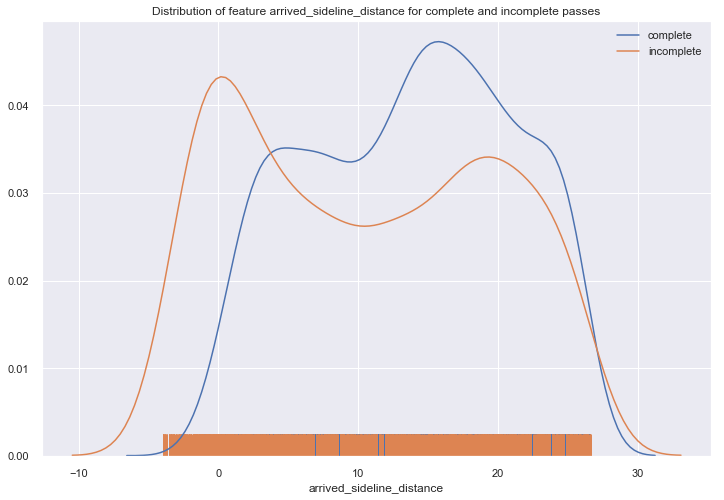

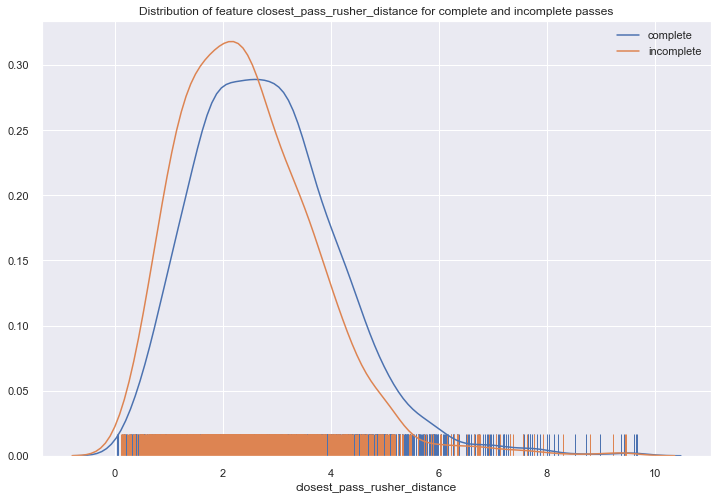

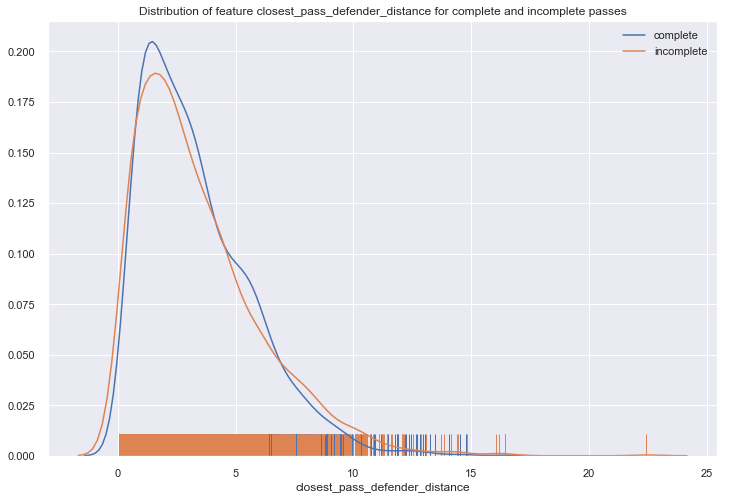

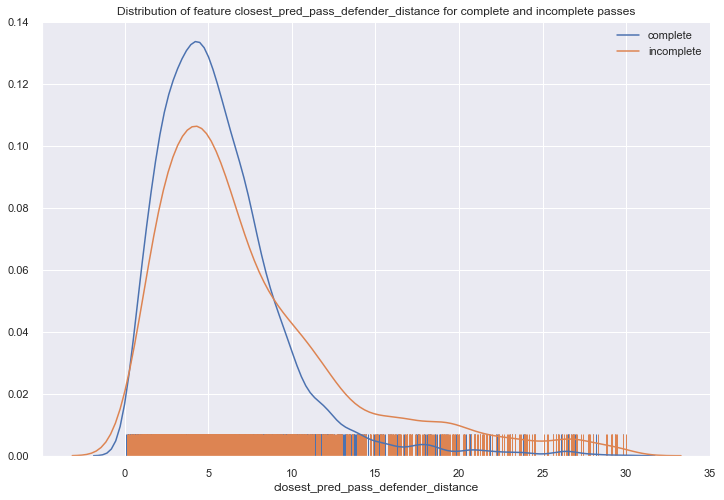

In [38]:
for feature in key_features:
    _comp_data = df_pred[_complete][feature]
    _inc_data = df_pred[_incomplete][feature]
    
    sns.distplot(a=_comp_data, label='complete', hist=False, rug=True)
    sns.distplot(a=_inc_data, label='incomplete', hist=False, rug=True)

    plt.title('Distribution of feature {:s} for complete and incomplete passes'.format(feature))
    plt.show()

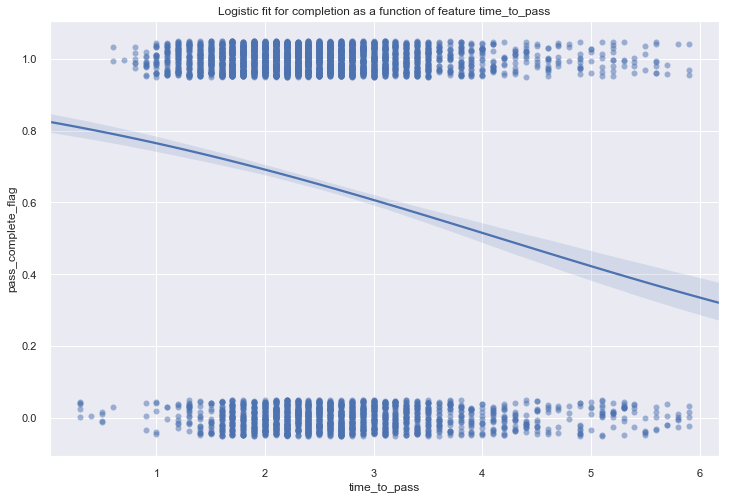

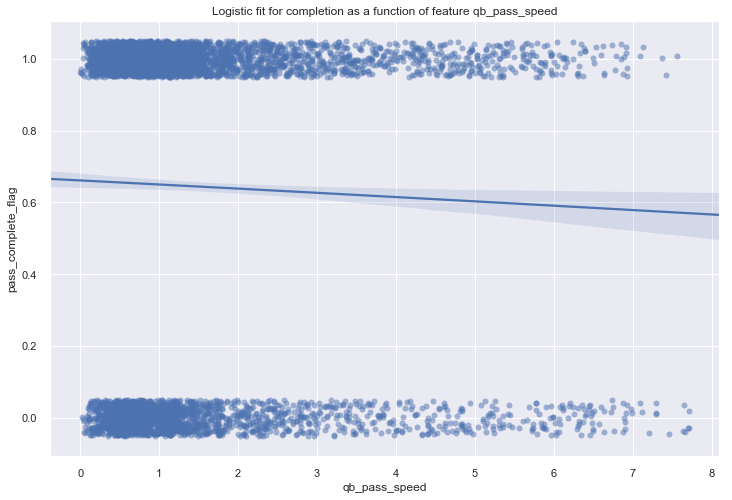

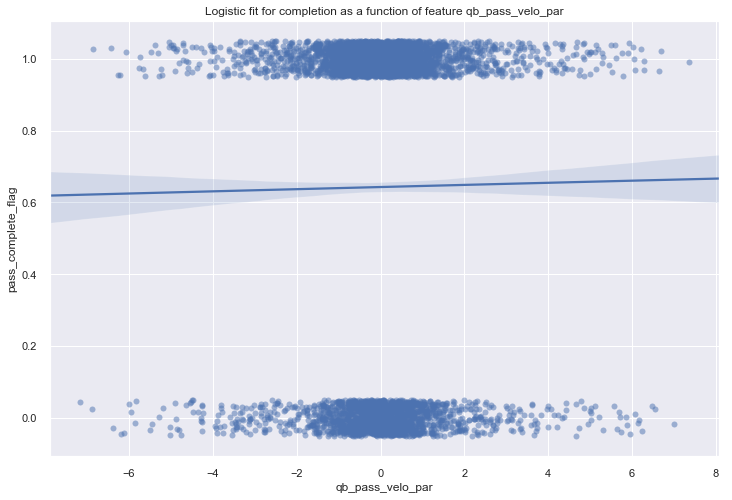

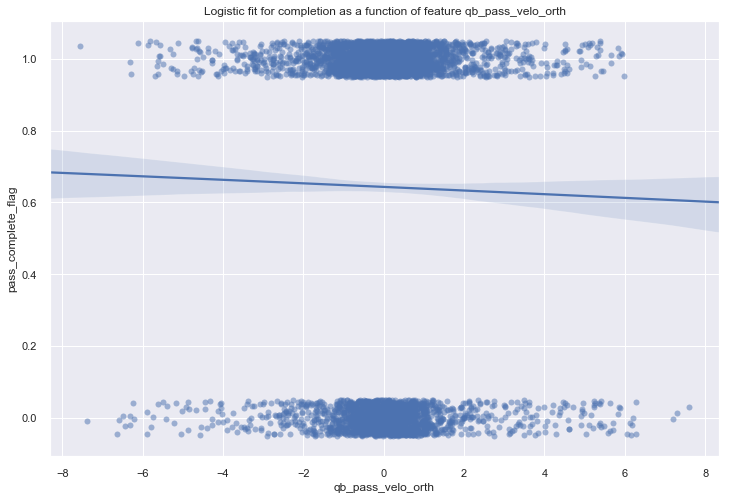

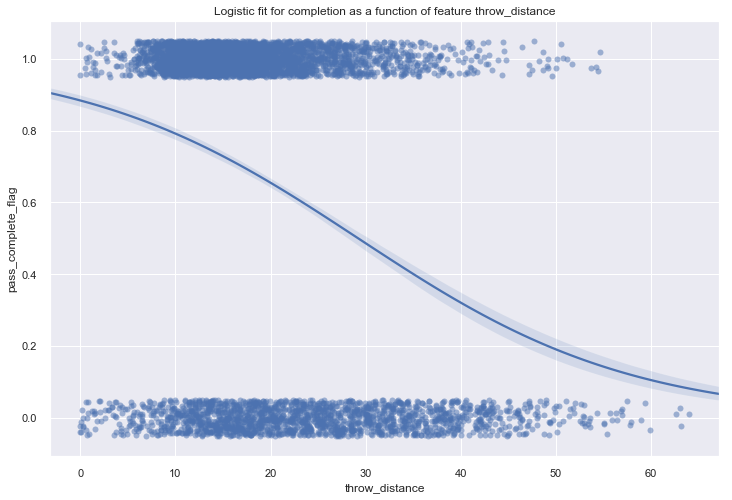

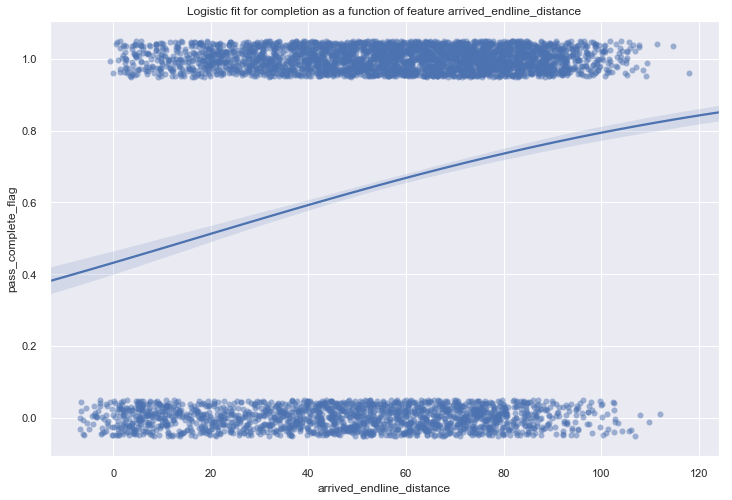

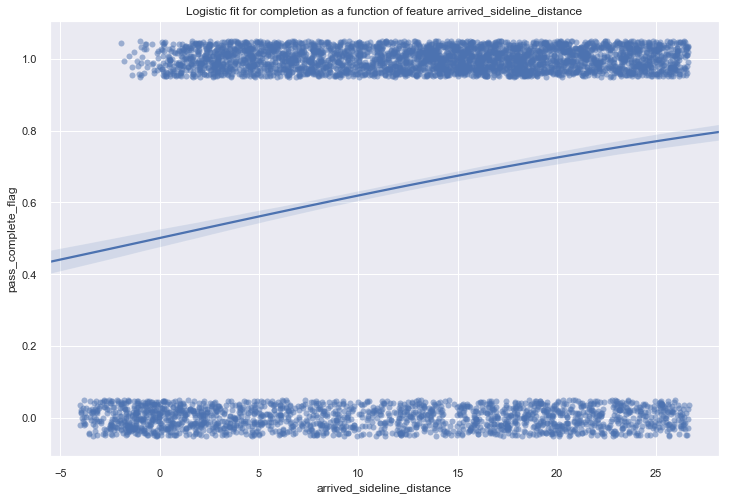

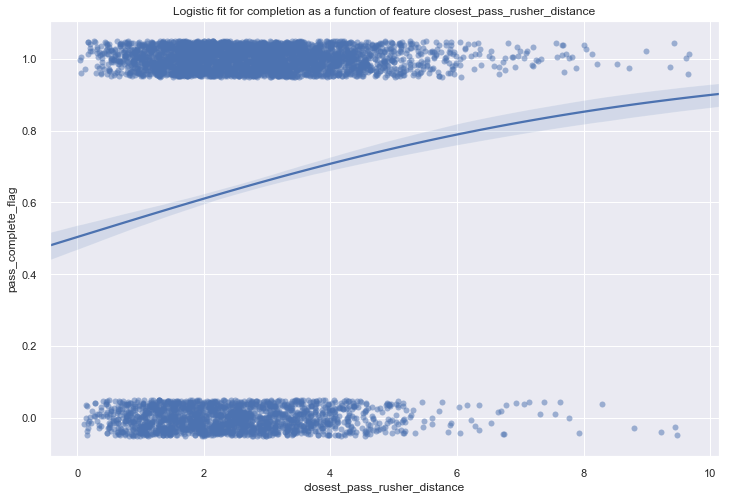

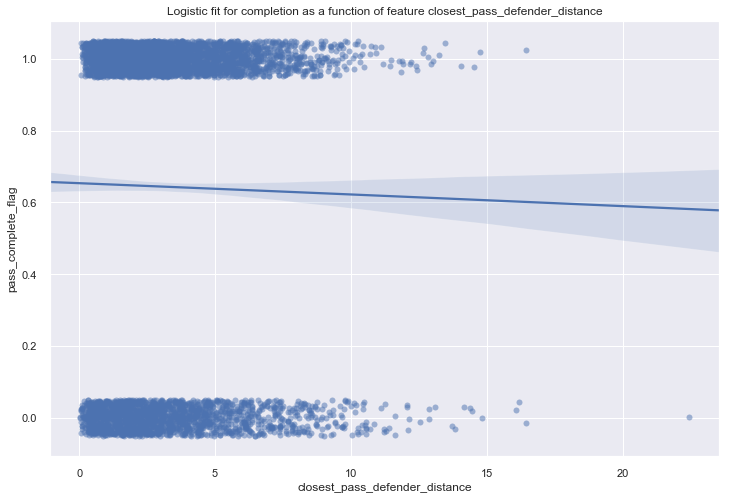

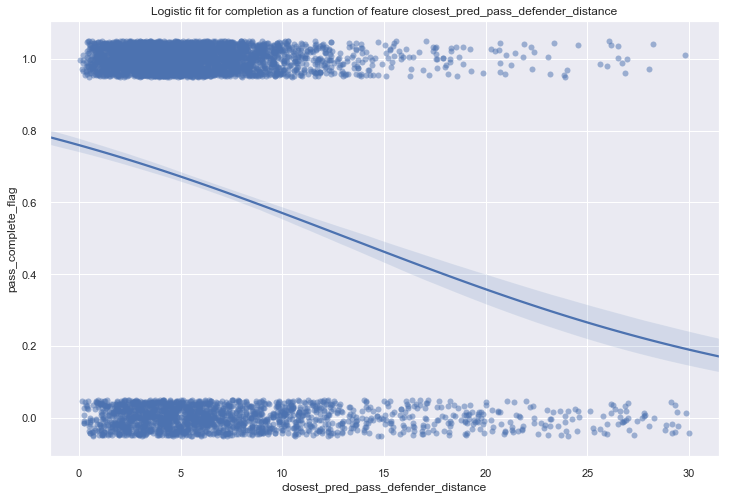

In [39]:
for feature in key_features:    
    sns.regplot(data=df_pred,
                x=feature,
                y='pass_complete_flag',
                logistic=True,
                y_jitter=0.05,
                scatter_kws={'alpha': 0.5})

    plt.title('Logistic fit for completion as a function of feature {:s}'.format(feature))
    plt.show()

## Modeling

### GAMs

In [40]:
def train_and_evaluate_gam(
        df,
        label,
        features,
        classes,
        model=None,
        constraints=None,
        lam=None,
        intercept=True,
        n_splines=10,
        resampler=None,
        test_size=0.2
    ):
    
    # Remove any NAs
    cols = features + [label]
    _df = df[cols].dropna(axis=0, how='any')

    # Handle None inputs
    if constraints is None:
        constraints = [None] * len(features)
        
    if lam is None:
        lam = np.logspace(-3, 3, 11)
    
    # Define X and y arrays
    X = _df[features].values
    y = _df[label].values
    
    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1, stratify=y)
        
    # Resample the data
    if resampler is not None:
        X_res, y_res = resampler.fit_resample(X_train, y_train)
    else:
        X_res, y_res = X_train, y_train
                
    # Train the model
    if model is None:
        model = LogisticGAM(n_splines=n_splines, fit_intercept=intercept)
    
    model.gridsearch(X_res,
                     y_res,
                     return_scores=True,
                     constraints=constraints,
                     lam=lam)

    num_terms = [ term for i, term in enumerate(model.terms) if not (term.istensor or term.isintercept) ]
    ten_terms = [ term for i, term in enumerate(model.terms) if term.istensor ]
    
    # Print GAM summary
    model.summary()
    
    # Plot individual features
    # Spline and factor terms
    plt.rcParams['figure.figsize'] = (28, 8)
    fig, axs = plt.subplots(1, len(num_terms))
    ax_idx = 0
        
    for i, term in enumerate(model.terms):
        if term.isintercept or term.istensor:
            continue
            
        XX = model.generate_X_grid(term=i)
        pdep, confi = model.partial_dependence(term=i, X=XX, width=0.9)

        if len(num_terms) > 1:
            ax = axs[ax_idx]
            ax_idx += 1
        else:
            ax = axs

        ax.plot(XX[:, term.feature], pdep)
        ax.plot(XX[:, term.feature], confi, c='r', ls='--')
        ax.set_title(term.feature)

    plt.show()
    
    # Tensor terms
    plt.rcParams['figure.figsize'] = (12, 8)
    
    for i, term in enumerate(model.terms):
        if not term.istensor:
            continue

        XX = model.generate_X_grid(term=i, meshgrid=True)
        Z = model.partial_dependence(term=i, X=XX, meshgrid=True)

        ax = plt.axes(projection='3d')
        ax.plot_surface(XX[0], XX[1], Z, cmap='viridis')
        plt.show()

    # Test the model against the held over test set
    y_pred_proba = model.predict_proba(X_test)
    y_pred = model.predict(X_test)
    
    # Model metrics
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    print("\nPrecision Score: {:3.3f}".format(precision_score(y_test, y_pred)))

    print("\nRecall Score: {:3.3f}".format(recall_score(y_test, y_pred)))

    print("\nF1 Score: {:3.3f}".format(f1_score(y_test, y_pred)))

    print("\nROC AUC Score: {:3.3f}".format(roc_auc_score(y_test, y_pred_proba)))

    print("\nAccuracy: {:3.3f}".format(accuracy_score(y_test, y_pred)))

    print("\nLog Loss: {:3.3f}".format(log_loss(y_test, y_pred_proba)))
    
    return model

100% (42 of 42) |########################| Elapsed Time: 0:00:10 Time:  0:00:10
/Users/ad/Documents/projects/nfl-bdb/venv/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 



LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     17.3593
Link Function:                        LogitLink Log Likelihood:                                 -2435.9441
Number of Samples:                         4342 AIC:                                             4906.6068
                                                AICc:                                            4906.7712
                                                UBRE:                                               3.1332
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1391
Feature Function                  Lam

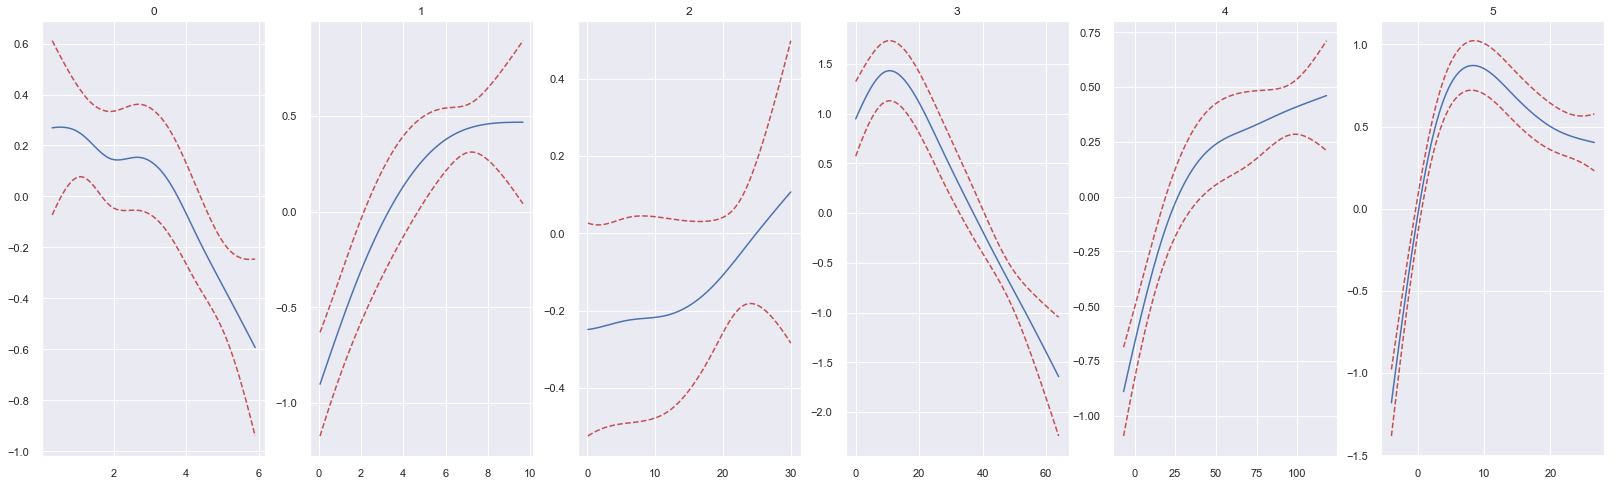


Confusion Matrix:
[[110 164]
 [ 42 451]]

Precision Score: 0.733

Recall Score: 0.915

F1 Score: 0.814

ROC AUC Score: 0.749

Accuracy: 0.731

Log Loss: 0.550


In [41]:
gam_label_1 = 'pass_complete_flag'
gam_classes_1 = ['incomplete', 'complete']
gam_features_1 = [
    'time_to_pass',
    'closest_pass_rusher_distance',
    'closest_pred_pass_defender_distance',
    'throw_distance',
    'arrived_endline_distance',
    'arrived_sideline_distance'
]
gam_constraints_1 = [None, 'monotonic_inc', None, None, None, None, None]
gam_lam_1 = np.logspace(1, 3, 7)
# gam_resampler_1 = SMOTE(random_state=42)
gam_model_1 = LogisticGAM(s(0, n_splines=10) +
                          s(1, n_splines=8, constraints='monotonic_inc') +
                          s(2, n_splines=8, constraints='monotonic_inc') +
                          s(3, n_splines=10) +
                          s(4, n_splines=8) +
                          s(5, n_splines=8))

completion_gam_1 = train_and_evaluate_gam(df=df_pred,
                                          label=gam_label_1,
                                          features=gam_features_1,
                                          classes=gam_classes_1,
                                          model=gam_model_1,
                                          lam=gam_lam_1,
                                          intercept=True,
                                          test_size=0.15)

100% (30 of 30) |########################| Elapsed Time: 0:02:54 Time:  0:02:54


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     41.0284
Link Function:                        LogitLink Log Likelihood:                                 -2385.8803
Number of Samples:                         4342 AIC:                                             4853.8175
                                                AICc:                                            4854.6589
                                                UBRE:                                               3.1254
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1568
Feature Function                  Lam

/Users/ad/Documents/projects/nfl-bdb/venv/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 



<Figure size 2016x576 with 0 Axes>

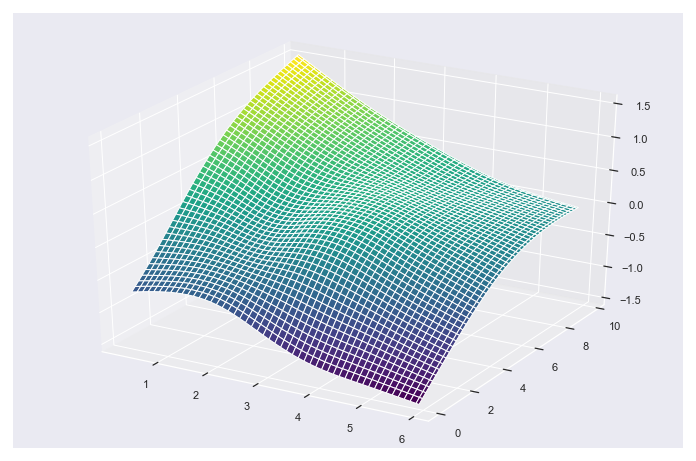

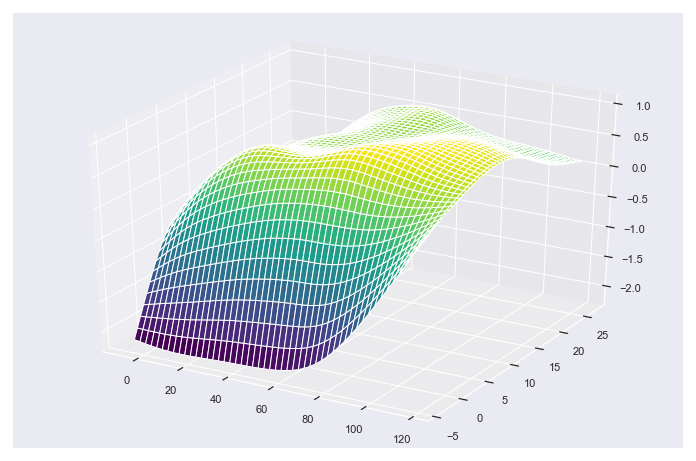

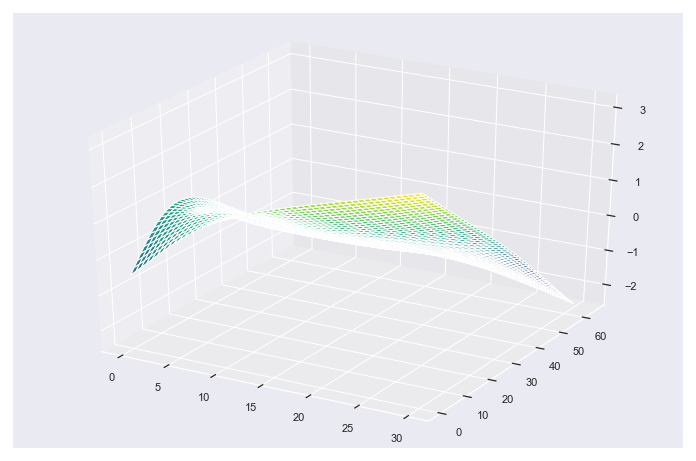


Confusion Matrix:
[[113 161]
 [ 42 451]]

Precision Score: 0.737

Recall Score: 0.915

F1 Score: 0.816

ROC AUC Score: 0.767

Accuracy: 0.735

Log Loss: 0.539


In [42]:
gam_label_2 = 'pass_complete_flag'
gam_classes_2 = ['incomplete', 'complete']
gam_features_2 = [
    'time_to_pass',
    'closest_pass_rusher_distance',
    'arrived_endline_distance',
    'arrived_sideline_distance',
    'closest_pred_pass_defender_distance',
    'throw_distance'
]
gam_lam_2 = np.logspace(1, 3, 5)
# gam_resampler_2 = SMOTE(random_state=42)
gam_model_2 = LogisticGAM(te(0, 1, n_splines=15) +
                          te(2, 3, n_splines=20) +
                          te(4, 5, n_splines=15))

completion_gam_2 = train_and_evaluate_gam(df=df_pred,
                                          label=gam_label_2,
                                          features=gam_features_2,
                                          classes=gam_classes_2,
                                          model=gam_model_2,
                                          lam=gam_lam_2,
                                          intercept=True,
                                          test_size=0.15)

100% (30 of 30) |########################| Elapsed Time: 0:02:53 Time:  0:02:53


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     38.0934
Link Function:                        LogitLink Log Likelihood:                                 -2423.5722
Number of Samples:                         4342 AIC:                                             4923.3312
                                                AICc:                                            4924.0599
                                                UBRE:                                               3.1409
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1435
Feature Function                  Lam

/Users/ad/Documents/projects/nfl-bdb/venv/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 



<Figure size 2016x576 with 0 Axes>

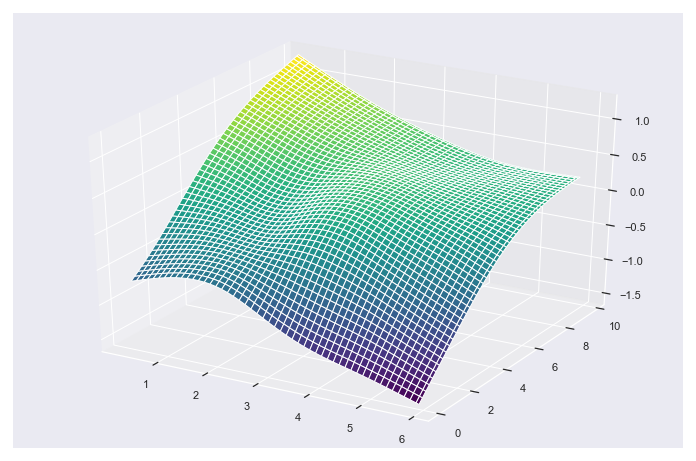

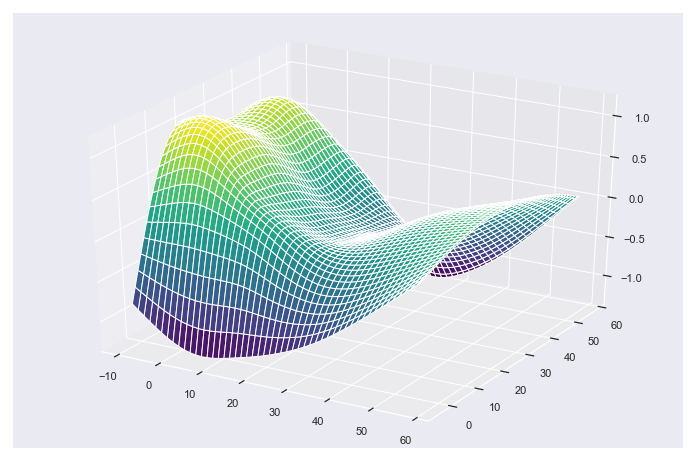

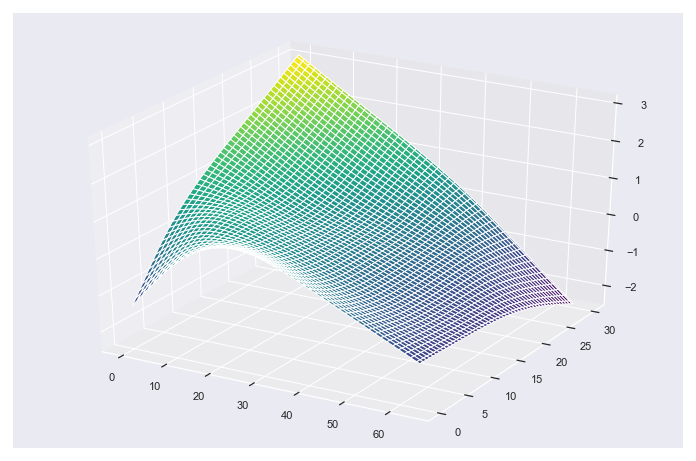


Confusion Matrix:
[[112 162]
 [ 52 441]]

Precision Score: 0.731

Recall Score: 0.895

F1 Score: 0.805

ROC AUC Score: 0.756

Accuracy: 0.721

Log Loss: 0.554


In [43]:
gam_label_3 = 'pass_complete_flag'
gam_classes_3 = ['incomplete', 'complete']
gam_features_3 = [
    'time_to_pass',
    'closest_pass_rusher_distance',
    'arrived_x_rel',
    'arrived_y',
    'throw_distance',
    'closest_pred_pass_defender_distance'
]
gam_lam_3 = np.logspace(1, 3, 5)
# gam_resampler_3 = SMOTE(random_state=42)
gam_model_3 = LogisticGAM(te(0, 1, n_splines=15) +
                          te(2, 3, n_splines=20) +
                          te(4, 5, n_splines=15))

completion_gam_3 = train_and_evaluate_gam(df=df_pred,
                                          label=gam_label_3,
                                          features=gam_features_3,
                                          classes=gam_classes_3,
                                          model=gam_model_3,
                                          lam=gam_lam_3,
                                          test_size=0.15)

### XGBoost

In [44]:
def train_and_evaluate_classifier(
        df,
        label,
        features,
        classes,
        classifier,
        xgb_scale=None,
        scaler=None,
        resampler=None,
        test_size=0.20
    ):
    
    # Remove any NAs
    cols = features + [label]
    _df = df[cols].dropna(axis=0, how='any')
    
    y = _df[label]
    X = _df[features]
    
    # Preprocessing
    if scaler is not None:
        try:
            X = scaler.fit_transform(X)
        except:
            print("Error:", sys.exc_info()[0])
            raise
        
    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42)
    
    # Resample the data
    if resampler is not None:
        X_res, y_res = resampler.fit_resample(X_train, y_train)
    else:
        X_res, y_res = X_train, y_train

    # Train the model
    classifier.fit(X_res, y_res)

    # Classifier description
    classifier_name = type(classifier).__name__
    if classifier_name in ['LogisticRegression']:
        print('COEFFICIENTS FOR {:s} CLASSIFIER'.format(classifier_name))
        
        intercept = classifier.intercept_
        if type(intercept) == np.ndarray:
            intercept = intercept[0]
        
        print("{:30}[{:5.3f}]".format('Intercept:', intercept))

        for feature, weight in list(zip(features, classifier.coef_[0])):
            print("{:30}[{:5.4f}]".format(feature + ":", weight))
        print('\n')
        
    if classifier_name in ['XGBClassifier']:
        plot_importance(classifier)
        plt.show()
        
    # Class prediction error plot
    cpe_plot = ClassPredictionError(classifier, classes=classes)
    cpe_plot.fit(X_train, y_train)
    cpe_plot.score(X_test, y_test)
    cpe_plot.poof()
    
    # Classification report
    cr_plot = ClassificationReport(classifier, classes=classes, support=True)
    cr_plot.fit(X_train, y_train)
    cr_plot.score(X_test, y_test)
    cr_plot.poof()
    
    # ROC/AUC plot
    rocauc_plot = ROCAUC(classifier, classes=classes)
    rocauc_plot.fit(X_train, y_train)
    rocauc_plot.score(X_test, y_test)
    rocauc_plot.poof()
    
    # Precision recall plot
    pr_plot = PrecisionRecallCurve(classifier)
    pr_plot.fit(X_train, y_train)
    pr_plot.score(X_test, y_test)
    pr_plot.poof()
        
    # Discrimination Threshold
    dt_plot = DiscriminationThreshold(classifier)
    dt_plot.fit(X_train, y_train)
    dt_plot.poof()
        
    return classifier

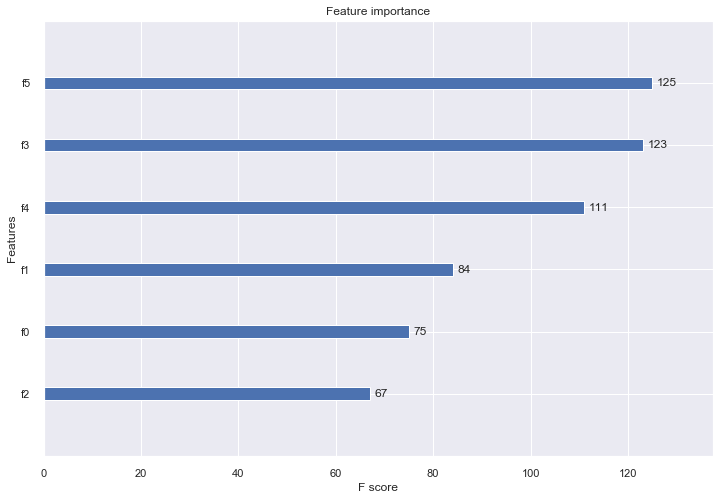

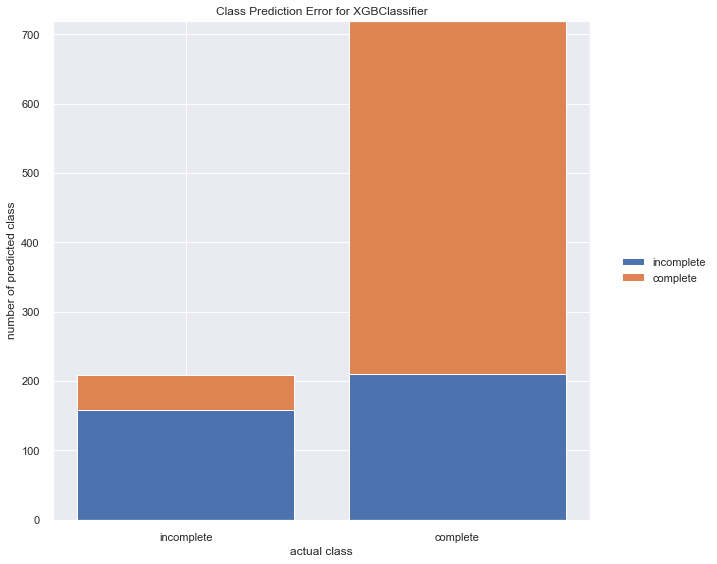

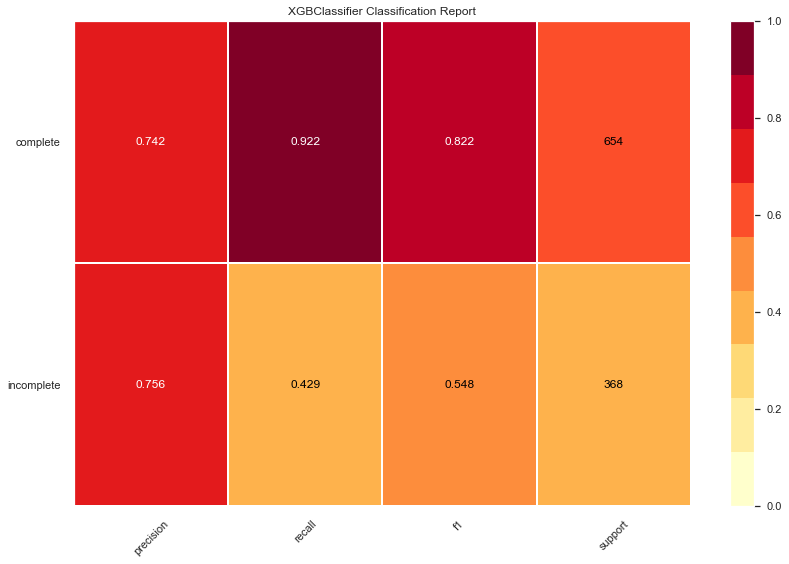

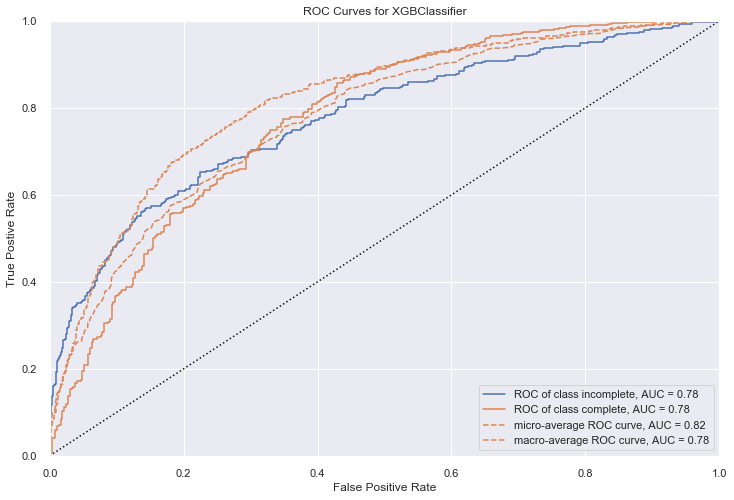

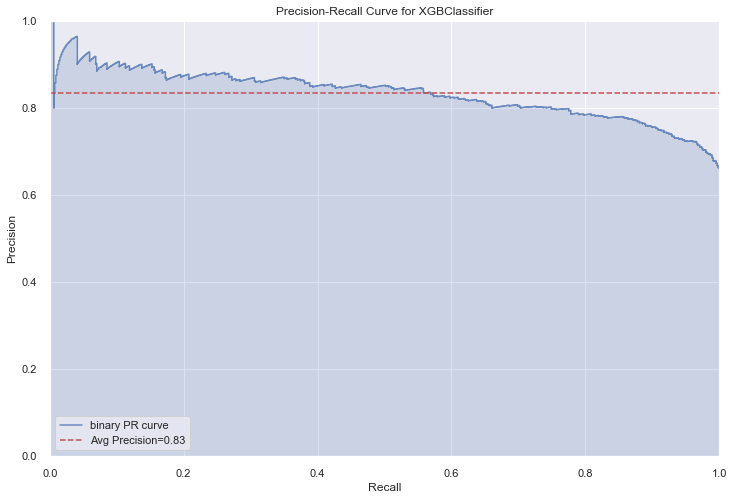

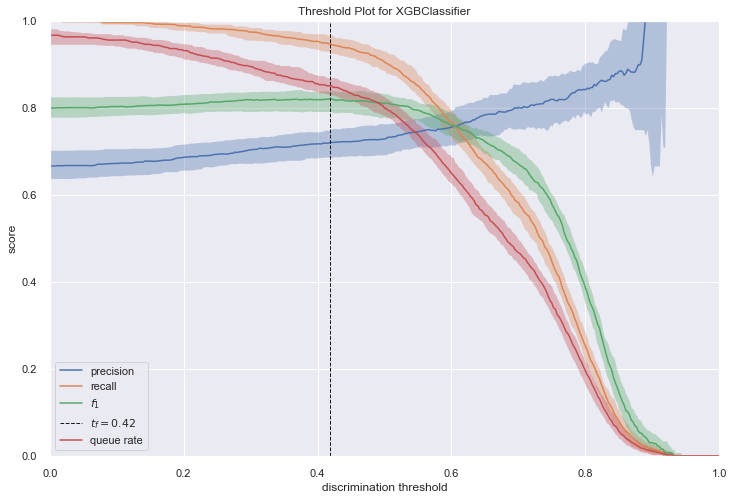

In [45]:
xgb_label_1 = 'pass_complete_flag'
xgb_classes_1 = ['incomplete', 'complete']
xgb_features_1 = [
    'time_to_pass',
    'closest_pass_rusher_distance',
    'arrived_x_rel',
    'arrived_sideline_distance',
    'closest_pred_pass_defender_distance',
    'throw_distance'
]

xgb_model_1 = XGBClassifier(scale_pos_weight=0.9)
xgb_scaler_1 = MaxAbsScaler()
# xgb_resampler_1 = RandomUnderSampler(random_state=42)

completion_xgb_1 = train_and_evaluate_classifier(df=df_pred,
                                                 label=xgb_label_1,
                                                 features=xgb_features_1,
                                                 classes=xgb_classes_1,
                                                 classifier=xgb_model_1,
                                                 scaler=xgb_scaler_1,
                                                 test_size=0.20)

## Model application

In [46]:
def apply_model(
        df,
        model,
        features,
        label,
        agg_column,
        count_column,
        scaler=None
    ):
    
    # Get useful features
    cols = features + [label, agg_column, count_column]
    output = df[cols].copy()
    output = output.dropna(axis=0, how='any')
        
    X = output[features]
    if scaler is not None:
        X = scaler.transform(X)
    
    pred_col = '{:s}_pred'.format(label)
    prob_col = '{:s}_prob'.format(label)
    
    # Generate predictions
    probs = model.predict_proba(X)
    if probs.ndim > 1:
        probs = np.asarray([ p[1] for p in probs ])
    
    output[pred_col] = model.predict(X)
    output[prob_col] = probs
        
    # Summarize results
    output_agg = output.groupby(agg_column).agg({
        label: 'mean',
        prob_col: 'mean',
        count_column: 'count'
    })
    
    output_agg = output_agg.rename(columns={
        count_column: 'count'
    })
    
    delta_col = '{:s}_delta'.format(label)
    output_agg[delta_col] = output_agg[label] - output_agg[prob_col]
    
    return output, output_agg

In [47]:
gam_qb, gam_qb_agg = apply_model(df=df_base,
                                 model=completion_gam_3,
                                 features=gam_features_3,
                                 label=gam_label_3,
                                 agg_column='qb_name',
                                 count_column='gameplay_id')

gam_qb_agg = gam_qb_agg[gam_qb_agg['count'] > 50]
gam_qb_agg = gam_qb_agg.rename(columns={
    'pass_complete_flag': 'completion_pct',
    'pass_complete_flag_prob': 'exp_completion_pct',
    'count': 'attempts',
    'pass_complete_flag_delta': 'completion_pct_delta'
})

gam_qb_agg.sort_values(by='exp_completion_pct', ascending=False).head(50)

completion_pct  exp_completion_pct  attempts  \
qb_name                                                            
Drew Brees                   0.677               0.662       158   
Mike Glennon                 0.631               0.660       122   
Philip Rivers                0.617               0.659       209   
Eli Manning                  0.652               0.656       198   
Jay Cutler                   0.583               0.655       151   
Derek Carr                   0.667               0.655       123   
Joe Flacco                   0.617               0.654       167   
Josh McCown                  0.720               0.652       157   
Tyrod Taylor                 0.632               0.648       125   
Andy Dalton                  0.630               0.646       138   
Aaron Rodgers                0.648               0.644       179   
Matt Ryan                    0.652               0.636       155   
Matthew Stafford             0.590               0.632       195   
Trevor Siemian               0.591               0.631       164   
Brian Hoyer                  0.557               0.626       185   
Carson Palmer                0.594               0.626       224   
Alex Smith                   0.698               0.621       169   
Dak Prescott                 0.620               0.621       163   
Tom Brady                    0.643               0.620       185   
Blake Bortles                0.550               0.619       149   
Kirk Cousins                 0.660               0.618       150   
Ben Roethlisberger           0.616               0.614       190   
Marcus Mariota               0.585               0.611       118   
Cam Newton                   0.634               0.610       186   
Kevin Hogan                  0.600               0.606        65   
Jared Goff                   0.590               0.603       173   
Carson Wentz                 0.614               0.602       184   
Jameis Winston               0.579               0.601       145   
DeShone Kizer                0.479               0.599       144   
Case Keenum                  0.628               0.599       145   
Jacoby Brissett              0.582               0.592       153   
Russell Wilson               0.614               0.577       158   
Deshaun Watson               0.598               0.573       122   

                    completion_pct_delta  
qb_name                                   
Drew Brees                         0.015  
Mike Glennon                      -0.029  
Philip Rivers                     -0.042  
Eli Manning                       -0.005  
Jay Cutler                        -0.072  
Derek Carr                         0.012  
Joe Flacco                        -0.038  
Josh McCown                        0.068  
Tyrod Taylor                      -0.016  
Andy Dalton                       -0.015  
Aaron Rodgers                      0.004  
Matt Ryan                          0.016  
Matthew Stafford                  -0.042  
Trevor Siemian                    -0.040  
Brian Hoyer                       -0.070  
Carson Palmer                     -0.032  
Alex Smith                         0.077  
Dak Prescott                      -0.002  
Tom Brady                          0.024  
Blake Bortles                     -0.069  
Kirk Cousins                       0.042  
Ben Roethlisberger                 0.001  
Marcus Mariota                    -0.026  
Cam Newton                         0.024  
Kevin Hogan                       -0.006  
Jared Goff                        -0.014  
Carson Wentz                       0.012  
Jameis Winston                    -0.021  
DeShone Kizer                     -0.120  
Case Keenum                        0.029  
Jacoby Brissett                   -0.010  
Russell Wilson                     0.037  
Deshaun Watson                     0.025

In [54]:
gam_qb.sort_values(by='pass_complete_flag_prob', ascending=True).head(25)

time_to_pass  closest_pass_rusher_distance  arrived_x_rel  arrived_y  \
2338         4.200                         2.330         58.000      1.000   
4143         5.300                         2.240        -61.000     36.000   
608          5.900                         1.450         11.000    -12.000   
4180         6.900                         1.610         13.000     69.000   
5235         5.400                         1.130         13.000    -10.000   
5190         2.500                         1.850         46.000     52.000   
192          4.100                         1.630         10.000    -11.000   
3636         3.100                         2.550         10.000    -10.000   
4654         3.400                         2.250         46.000     56.000   
3575         3.800                         3.350         48.000      1.000   
2191         2.300                         3.110         44.000     -3.000   
4781         3.900                         0.460         45.000     55.000   
4506         3.600                         1.690         49.000     15.000   
2142         2.700                         2.930         45.000     48.000   
2746         3.100                         0.230         45.000     50.000   
895          3.100                         1.950         41.000     59.000   
1265         8.300                         0.600         22.000     -6.000   
4220         5.700                         2.670         15.000     -7.000   
3162         8.300                         4.240          8.000     -9.000   
1940         3.400                         1.670         49.000     48.000   
4868         6.000                         1.840         21.000     62.000   
3741         5.700                         1.280         14.000     61.000   
1251         6.500                         2.470         50.000     43.000   
2379         2.700                         2.470         49.000     44.000   
1088         3.200                         2.410         47.000     49.000   

      throw_distance  closest_pred_pass_defender_distance  pass_complete_flag  \
2338          66.720                               60.200                   0   
4143          59.370                               54.230                   1   
608           26.250                               17.450                   0   
4180          24.420                               17.420                   0   
5235          37.300                                6.630                   0   
5190          59.400                               49.850                   0   
192           35.160                                6.060                   0   
3636          48.760                               11.910                   0   
4654          62.660                               37.830                   0   
3575          65.300                               41.470                   0   
2191          59.790                               46.450                   0   
4781          62.580                               25.790                   0   
4506          58.780                               53.170                   1   
2142          57.090                               56.490                   0   
2746          55.820                               41.770                   1   
895           58.300                               36.180                   0   
1265          24.150                                5.200                   0   
4220          41.330                               11.760                   0   
3162          16.390                                7.180                   0   
1940          57.980                               43.540                   1   
4868          33.450                               18.070                   0   
3741          33.040                                8.740                   0   
1251          57.850                               34.100                   0   
2379          61.960             

In [50]:
gam_wr, gam_wr_agg = apply_model(df=df_pred,
                                 model=completion_gam_3,
                                 features=gam_features_3,
                                 label=gam_label_3,
                                 agg_column='receiver_name',
                                 count_column='gameplay_id')

gam_wr_agg = gam_wr_agg[gam_wr_agg['count'] > 15]
gam_wr_agg = gam_wr_agg.rename(columns={
    'pass_complete_flag': 'completion_pct',
    'pass_complete_flag_prob': 'exp_completion_pct',
    'count': 'targets',
    'pass_complete_flag_delta': 'completion_pct_delta'
})


gam_wr_agg.sort_values(by='exp_completion_pct', ascending=True).head(50)

completion_pct  exp_completion_pct  targets  \
receiver_name                                                   
Paul Richardson            0.500               0.460       24   
Tyler Higbee               0.417               0.505       24   
Marvin Jones               0.500               0.508       26   
Stefon Diggs               0.640               0.509       25   
John Brown                 0.500               0.511       24   
Donte Moncrief             0.667               0.522       18   
Robby Anderson             0.444               0.525       27   
DeAndre Hopkins            0.533               0.528       45   
Torrey Smith               0.579               0.528       19   
Jaron Brown                0.542               0.528       24   
DeSean Jackson             0.542               0.531       24   
Zay Jones                  0.278               0.536       18   
Marquise Goodwin           0.464               0.537       28   
T.Y. Hilton                0.625               0.540       32   
DeVante Parker             0.619               0.541       21   
Kenny Britt                0.263               0.545       19   
Aldrick Robinson           0.348               0.554       23   
Devin Funchess             0.649               0.554       37   
Ryan Grant                 0.650               0.556       20   
J.J. Nelson                0.588               0.556       17   
Dez Bryant                 0.459               0.557       37   
Ed Dickson                 0.565               0.557       23   
Tyler Lockett              0.684               0.565       19   
Travis Benjamin            0.611               0.566       18   
Mike Wallace               0.565               0.570       23   
Adam Thielen               0.735               0.571       49   
Kenny Stills               0.550               0.575       20   
Mike Evans                 0.514               0.575       35   
Rishard Matthews           0.583               0.581       36   
Allen Hurns                0.720               0.581       25   
Marqise Lee                0.536               0.582       28   
Pierre Garcon              0.553               0.582       47   
Brandin Cooks              0.571               0.583       28   
Michael Crabtree           0.700               0.587       30   
Kamar Aiken                0.333               0.589       27   
Ted Ginn                   0.706               0.592       17   
Demaryius Thomas           0.676               0.592       37   
Terrelle Pryor             0.636               0.596       22   
Kelvin Benjamin            0.688               0.597       32   
Robert Woods               0.621               0.598       29   
Odell Beckham              0.594               0.599       32   
Jordy Nelson               0.677               0.601       31   
Hunter Henry               0.636               0.603       22   
Ricardo Louis              0.615               0.603       26   
Antonio Brown              0.706               0.606       51   
Tyreek Hill                0.719               0.606       32   
Taylor Gabriel             0.682               0.606       22   
Cole Beasley               0.583               0.606       24   
Kyle Rudolph               0.562               0.607       32   
Jared Cook                 0.655               0.608       29   

                  completion_pct_delta  
receiver_name                           
Paul Richardson                  0.040  
Tyler Higbee                    -0.088  
Marvin Jones                    -0.008  
Stefon Diggs                     0.131  
John Brown                      -0.011  
Donte Moncrief                   0.144  
Robby Anderson                  -0.081  
DeAndre Hopkins                  0.006  
Torrey Smith                     0.051  
Jaron Brown                      0.014  
DeSean Jackson                   0.011  
Zay Jones                       -0.258  
Marquise Goodwin                -0.073  
T.Y. Hilton           

In [51]:
xgb_qb, xgb_qb_agg = apply_model(df=df_pred,
                                 model=completion_xgb_1,
                                 features=xgb_features_1,
                                 label=xgb_label_1,
                                 agg_column='qb_name',
                                 count_column='gameplay_id',
                                 scaler=xgb_scaler_1)

xgb_qb_agg = xgb_qb_agg[xgb_qb_agg['count'] > 50]
xgb_qb_agg = xgb_qb_agg.rename(columns={
    'pass_complete_flag': 'completion_pct',
    'pass_complete_flag_prob': 'exp_completion_pct',
    'count': 'attempts',
    'pass_complete_flag_delta': 'completion_pct_delta'
})

xgb_qb_agg.sort_values(by='exp_completion_pct', ascending=False).head(50)

completion_pct  exp_completion_pct  attempts  \
qb_name                                                            
Joe Flacco                   0.652               0.664       155   
Drew Brees                   0.680               0.662       153   
Aaron Rodgers                0.690               0.662       158   
Mike Glennon                 0.647               0.661       119   
Josh McCown                  0.753               0.657       146   
Philip Rivers                0.633               0.656       199   
Derek Carr                   0.692               0.653       117   
Eli Manning                  0.668               0.647       184   
Ben Roethlisberger           0.669               0.643       163   
Jay Cutler                   0.592               0.637       142   
Andy Dalton                  0.686               0.637       121   
Matthew Stafford             0.628               0.637       180   
Alex Smith                   0.718               0.632       156   
Tom Brady                    0.661               0.630       174   
Matt Ryan                    0.683               0.630       145   
Carson Palmer                0.624               0.626       205   
Carson Wentz                 0.671               0.625       158   
Kirk Cousins                 0.703               0.624       138   
Tyrod Taylor                 0.652               0.622       115   
Brian Hoyer                  0.559               0.622       177   
Trevor Siemian               0.632               0.617       144   
Cam Newton                   0.657               0.615       172   
Jacoby Brissett              0.623               0.614       138   
Case Keenum                  0.669               0.609       133   
Dak Prescott                 0.619               0.608       155   
Marcus Mariota               0.615               0.606       109   
DeShone Kizer                0.507               0.604       134   
Blake Bortles                0.577               0.604       137   
Jared Goff                   0.611               0.602       162   
Deshaun Watson               0.615               0.600       104   
Kevin Hogan                  0.672               0.591        58   
Jameis Winston               0.596               0.586       136   
Russell Wilson               0.647               0.563       150   

                    completion_pct_delta  
qb_name                                   
Joe Flacco                        -0.012  
Drew Brees                         0.017  
Aaron Rodgers                      0.028  
Mike Glennon                      -0.014  
Josh McCown                        0.097  
Philip Rivers                     -0.022  
Derek Carr                         0.039  
Eli Manning                        0.021  
Ben Roethlisberger                 0.026  
Jay Cutler                        -0.046  
Andy Dalton                        0.049  
Matthew Stafford                  -0.009  
Alex Smith                         0.086  
Tom Brady                          0.031  
Matt Ryan                          0.053  
Carson Palmer                     -0.002  
Carson Wentz                       0.046  
Kirk Cousins                       0.079  
Tyrod Taylor                       0.030  
Brian Hoyer                       -0.062  
Trevor Siemian                     0.015  
Cam Newton                         0.042  
Jacoby Brissett                    0.010  
Case Keenum                        0.060  
Dak Prescott                       0.011  
Marcus Mariota                     0.009  
DeShone Kizer                     -0.096  
Blake Bortles                     -0.027  
Jared Goff                         0.009  
Deshaun Watson                     0.015  
Kevin Hogan                        0.081  
Jameis Winston                     0.010  
Russell Wilson                     0.084

In [ ]:
model_qb_agg = pd.merge(gam_qb_agg,
                        xgb_qb_agg,
                        on='qb_name',
                        suffixes=['_gam', '_xgb'])

In [ ]:
model_qb_agg.head()

In [ ]:
sns.scatterplot(data=model_qb_agg,
                x='completion_pct_delta_gam',
                y='completion_pct_delta_xgb',
                size='attempts_gam')